# Importing libraries

In [1]:
#pip install pyarabic
#pip install networkx
#pip install matplotlib
#pip install arabic-reshaper
#pip install python_bidi

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.stem import PorterStemmer
from snowballstemmer import stemmer
import pyarabic.araby as araby
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import string
import re
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Sara
[nltk_data]     Aljamal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sara
[nltk_data]     Aljamal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading preprocessed data

In [3]:
unique_df=pd.read_excel(r"C:\Users\Sara Aljamal\Desktop\notebook\uniqueData.xlsx")

In [4]:
unique_df=unique_df.drop(['Unnamed: 0'],axis=1)
unique_df

,CASE_DESC,preprocessed
0,إعادة برمجة من النظامby Sultan,اعاد رمج نظامbi sultan
1,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,عدم تصفح سوء خدمه والرجاء اتخاذ قرار سكان رويش...
2,Activation date Sep 22 2022 لم يتم اضافة ا...,activ date sep يتم اضاف حزم رقم تواصل 96278942...
3,Never connected ONT UnknownCONTACT NUMBER ...,never connect ont unknowncontact number
4,Never connected ONTUnknown07994746460790205560,never connect ontunknown
...,...,...
118901,يوم السبت تم اخدعا من معرض دار ابو سعيد 899627...,يوم سبت تم اخدع معرض دار ابو سعيد gb
118902,يوووجد للزبون خصم بقيمة 50%بالمسجات التي تم دف...,يوووجد للزب خصم قيم مسج تم دفع مبلغ يرجي عمل ا...
118903,ييريد تقديم شكووى على مندوب بسبب عند توقيع ال...,ييريد تقديم شكووي مندوب سبب توقيع عقد الزب تم ...
118904,ئة البطاقة 12 دينار الإقتطاع: 12545 1754التاري...,يه بطاقه اقتطاع تاريخ وقت مساء اسم بنك بنك عرب...


In [5]:
unique_df.isnull().sum()

CASE_DESC       0
preprocessed    1
dtype: int64

In [6]:
unique_df=unique_df.dropna()

In [7]:
preprocessed_documents=unique_df['preprocessed'].tolist()

In [8]:
len(preprocessed_documents)

118905

# Preprocessing functions

In [9]:
def normalizee(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    return text

In [10]:
def remove_symbols(text):
    symbols_to_remove = r'/+-*)\(&%#.,؛:_$^'
    cleaned_text = re.sub('[' + re.escape(symbols_to_remove) + ']', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return cleaned_text

In [11]:
def preprocess_text(text):
    # 1. Tokenization
    tokens = nltk.word_tokenize(text)

    # 2. Lowercase conversion
    tokens = [token.lower() for token in tokens]

    # 3. Remove punctuation
    tokens = [token for token in tokens if re.match(r'\w', token)]

    # 4. Remove stopwords
    english_stop_words = set(stopwords.words('english'))
    arabic_stop_words = set(stopwords.words('arabic'))
    tokens = [token for token in tokens if token not in english_stop_words and token not in arabic_stop_words]

    # 5. Stemming
    en_stemmer = PorterStemmer()
    ar_stemmer = stemmer("arabic")
    tokens = [en_stemmer.stem(token) for token in tokens]
    tokens = [ar_stemmer.stemWord(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# GUI

In [14]:
def get_complaints():
        query = entry_id.get()
        query1=araby.strip_tashkeel(query) 
        query1=normalizee(query1)
        query1=remove_symbols(query1)
        query1=preprocess_text(query1)
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(preprocessed_documents)
        query_tfidf = vectorizer.transform([query1])
        cosine_similarit= cosine_similarity(tfidf_matrix, query_tfidf)
        unique_df.loc[:, 'cosine distances'] = cosine_similarit
        top_5= unique_df['cosine distances'].nlargest(5)
        top5_index=top_5.index
        top5_values=top_5.values
        global top5_df
        top5_df=unique_df[['CASE_DESC','preprocessed']].loc[top5_index].copy()
        info_text_1.set("\n".join(top5_df['CASE_DESC']))

In [21]:
def get_directed_graph():

    global Graph1
    Graph1=nx.DiGraph()
    tokenized= [nltk.word_tokenize(doc) for doc in top5_df['preprocessed']]
    merged_tokens = [word for sublist in tokenized for word in sublist]
    set_tokenized=set(merged_tokens)
    Graph1.add_nodes_from(set_tokenized)
    node_labels = {node: get_display(reshape(node)) for node in Graph1.nodes()}
    edge=[]
    for i in tokenized:
      temp=[]
      for j in i:
        temp.append(j)
        if (len(temp)==2):
          edge.append(tuple(temp))
          temp=[]
          temp.append(j)
    Graph1.add_edges_from(edge)
    graph_window = tk.Toplevel()
    graph_window.title("Directed Graph")
    fig, ax = plt.subplots(figsize=(12, 10))
    pos = nx.circular_layout(Graph1)  
    nx.draw(Graph1, pos,
            with_labels=True, labels=node_labels, arrows=True,arrowsize=20,node_size=2500,node_color='#FF6600',
            font_size=10, font_color='black', font_weight='bold', edge_color='black', linewidths=1)
    canvas = FigureCanvasTkAgg(fig, master=graph_window)                                        
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)


In [22]:
def get_centrality_measures():
    degree=nx.degree_centrality(Graph1)
    betweenness=nx.betweenness_centrality(Graph1)
    closeness=nx.closeness_centrality(Graph1)
    info_text_2.set(f"Degree centrality: {degree} \nBetweenness centrality: {betweenness}\nCloseness centrality: {closeness}")

In [25]:
def get_undirected_graph():
    tokenized= [nltk.word_tokenize(doc) for doc in top5_df['preprocessed']]
    merged_tokens = [word for sublist in tokenized for word in sublist]
    set_tokenized=set(merged_tokens)
    Graph2= nx.Graph()
    Graph2.add_nodes_from(set_tokenized)
    node_labels = {node: get_display(reshape(node)) for node in Graph2.nodes()}
    combinations=[]
    for sublist in tokenized:
        for i in range(len(sublist)):
            for j in range(len(sublist)):
                if i!=j:
                  if (sublist[j], sublist[i]) not in combinations:
                   combinations.append((sublist[i], sublist[j]))

    combinations_dict = {}
    for pair in combinations:
     combinations_dict[pair] = combinations_dict.get(pair, 0) + 1
    edges = [(pair[0], pair[1], min(count,5)) for pair, count in combinations_dict.items()]
    Graph2.add_weighted_edges_from(edges)
    edge_weights = nx.get_edge_attributes(Graph2, 'weight')
    graph_window = tk.Toplevel()
    graph_window.title("Undirected Graph")
    pos = nx.circular_layout(Graph2)
    fig, ax = plt.subplots(figsize=(14,10))
    nx.draw(Graph2, pos, labels=node_labels, with_labels=True, node_size=2000, node_color='#FF6600',
        font_size=10, font_color='black', font_weight='bold', edge_color='black', linewidths=1, arrows=False, ax=ax)
    nx.draw_networkx_edge_labels(Graph2, pos, edge_labels=edge_weights)
    canvas = FigureCanvasTkAgg(fig, master=graph_window)                                        
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)


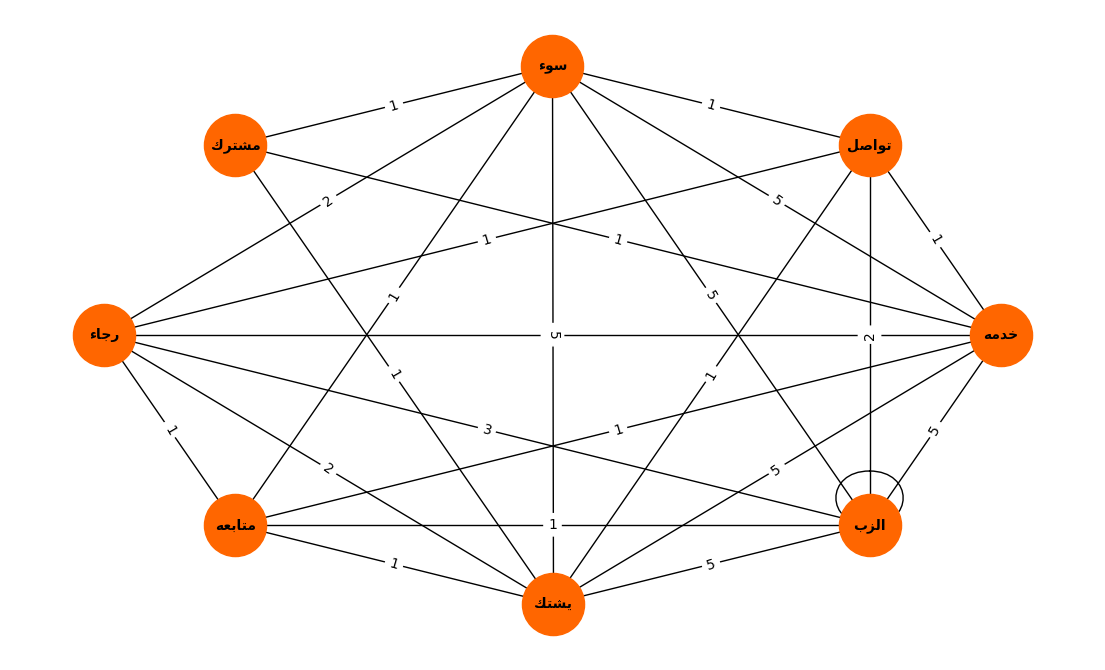

In [26]:
# Create the main window
root = tk.Tk()
root.title("Complaints tracker")
root.geometry("1500x900")

# # Load an image (replace 'path_to_your_image.png' with the actual path to your image file)
image_path = r"C:\Users\Sara Aljamal\Desktop\notebook\logo.png"
img = tk.PhotoImage(file=image_path)

# Create and place widgets
label_image = tk.Label(root, image=img)
label_image.pack(pady=5,anchor=tk.NE)

# Create and place widgets
label_id = tk.Label(root, text="Enter a complaint:",font=("DM Serif Display", 14, "bold"), fg="#FF6600")
label_id.pack(pady=10)

entry_id = tk.Entry(root,width=30)
entry_id.pack(pady=10)

complaints_button = tk.Button(root, text="Get Complaints",command=get_complaints, width=30)
complaints_button.pack(pady=10)

info_text_1 = tk.StringVar()
label_info_1 = tk.Label(root, textvariable=info_text_1)
label_info_1.pack(pady=10)

directed_graph_button = tk.Button(root, text="Get the directed graph", command=get_directed_graph,width=30)
directed_graph_button.pack(pady=10)

centrality_measures_button = tk.Button(root, text="Get the centrality measures", command=get_centrality_measures,width=30)
centrality_measures_button.pack(pady=10)

info_text_2 = tk.StringVar()
label_info_2 = tk.Label(root, textvariable=info_text_2)
label_info_2.pack(pady=10)

undirected_graph_button = tk.Button(root, text="Get the undirected graph", command=get_undirected_graph,width=30)
undirected_graph_button.pack(pady=10)

root.mainloop()